In [17]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import cmath
import scipy as sp
%matplotlib inline
from scipy import integrate

In [8]:
u_inf = 1.0             # free-stream speed

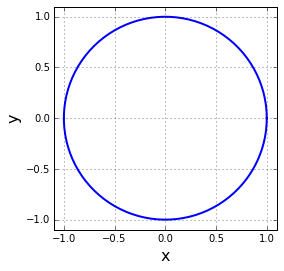

In [9]:
# defines the cylinder
R = 1.0                                                     # radius
theta = np.linspace(0, 2*np.pi, 100)                           # angles in radians
x_cylinder, y_cylinder = R*np.cos(theta), R*np.sin(theta)   # coordinates of the cylinder

# plots the cylinder
%matplotlib inline

size = 4
plt.figure(figsize=(size, size))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=2)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1);

In [13]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

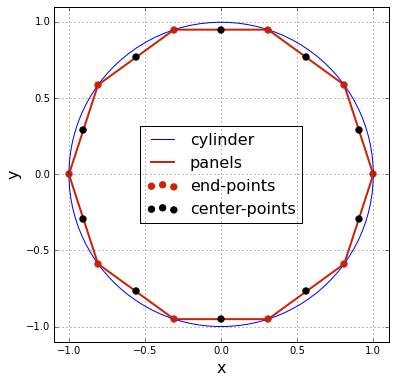

In [14]:
N_panels = 10                    # number of panels desired

# defining the end-points of the panels
x_ends = R*np.cos(np.linspace(0, 2*np.pi, N_panels+1))
y_ends = R*np.sin(np.linspace(0, 2*np.pi, N_panels+1))

# defining the panels
panels = np.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
# plotting the panels
size = 6
plt.figure(figsize=(size, size))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x_cylinder, y_cylinder, color='b', linestyle='-', linewidth=1)
plt.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
plt.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
plt.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', s=40, zorder=3)
plt.legend(['cylinder', 'panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1);

In [15]:
def integral_normal(p_i, p_j):
    """Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Arguments
    ---------
    p_i -- panel on which the contribution is calculated.
    p_j -- panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel of the influence at a control-point.
    """
    def func(s):
        return ( (+(p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))*np.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))*np.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))**2) )
    return sp.integrate.quad(lambda s:func(s), 0., p_j.length)[0]

### Solving the system of equations

We just developed an equation to enforce a flow-tangency condition on the $i$-th panel. There are `N_panels` panels $i$ and `N_panels` unknown strengths $\sigma_i$. Therefore, the problem represents solving a linear system of equations of the form

$$[A][\sigma] = [b]$$

where

$$A_{ij} = \begin{cases}
\begin{matrix}
\frac{1}{2} & \mbox{, if } i=j \cr
\frac{1}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} ds_j & \mbox{, if } i\neq j
\end{matrix}
\end{cases}$$

and

$$b_i = - U_\infty \cos\beta_i$$

for $1\leq i,j \leq N_p$. Let's fill a matrix $A$ and a right-hand-side vector $b$ with the necessary values:

In [18]:
# computes the source influence matrix
A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.5)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/np.pi*integral_normal(p_i, p_j)

# computes the RHS of the linear system
b = - u_inf * np.cos([p.beta for p in panels])

In [19]:
# solves the linear system
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

In [20]:
def integral_tangential(p_i, p_j):
    """Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Arguments
    ---------
    p_i -- panel on which the contribution is calculated.
    p_j -- panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel of the influence at a control-point.
    """
    def func(s):
        return ( (-(p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))*np.sin(p_i.beta)
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))*np.cos(p_i.beta))
                /((p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))**2) )
    return sp.integrate.quad(lambda s:func(s),0.,p_j.length)[0]

In [21]:
# computes the matrix of the linear system
A = np.empty((N_panels, N_panels), dtype=float)
np.fill_diagonal(A, 0.0)

for i, p_i in enumerate(panels):
    for j, p_j in enumerate(panels):
        if i != j:
            A[i,j] = 0.5/np.pi*integral_tangential(p_i, p_j)

# computes the RHS of the linear system
b = - u_inf * np.sin([panel.beta for panel in panels])

# computes the tangential velocity at each panel center-point
vt = np.dot(A, sigma) + b

for i, panel in enumerate(panels):
    panel.vt = vt[i]

In [22]:
# calculates the surface pressure coefficient
for panel in panels:
    panel.cp = 1.0 - (panel.vt/u_inf)**2

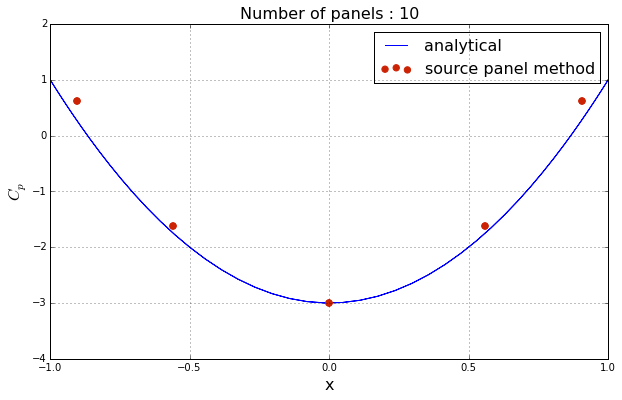

In [23]:
# calculates the analytical surface pressure coefficient
cp_analytical = 1.0 - 4*(y_cylinder/R)**2

# plots the surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot(x_cylinder, cp_analytical, color='b', linestyle='-', linewidth=1, zorder=1)
plt.scatter([p.xc for p in panels], [p.cp for p in panels], color='#CD2305', s=40, zorder=2)
plt.title('Number of panels : %d' % N_panels, fontsize=16)
plt.legend(['analytical', 'source panel method'], loc='best', prop={'size':16})
plt.xlim(-1.0, 1.0)
plt.ylim(-4.0, 2.0);